# Parallel tasks on Aquila

For jobs with a small number of registers one we can sure to maximize the full area allowed by the simulator. In this tutorial we go through the previously explored checkerboad preparation but now taking advantage of the full simulation area. 

We will break up each portion of the total area into __batches__ which will all run in parallel. 


## Defining batches

First, we will define a _single_ batch containing a 3x3 grid of atoms

In [1]:
from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

In [2]:
import numpy as np

# distance between atoms
scale = 6.7e-6

# number of atoms in a batch
Lx = 3
Ly = 3

register = AtomArrangement()

for ix in range(Lx):
    for iy in range(Ly):
        pos = (ix * scale, iy * scale)
        register.add(pos)

## Bounding batches

Next, we define a box that bounds the batch by calculating its width and height. This will prove useful in setting up multiple batches in parallel in the area Aquila provides.

In [3]:
x_min = min(*[site.coordinate[0] for site in register])
x_max = max(*[site.coordinate[0] for site in register])
y_min = min(*[site.coordinate[1] for site in register])
y_max = max(*[site.coordinate[1] for site in register])

single_problem_width = x_max - x_min
single_problem_height = y_max - y_min

### Calculating batch placement

To prevent entanglement via the Rydberg interaction between batches, we need to place them far apart. Each batch consists of an area proportional to the bounding box of the register as well as padding to enforce this.

In this case we pick the distance between the batches to be:

$$3 \ \times \text{scale}$$

with $\text{scale}$ being the distance between atoms in a single batch which means the ratio between intra- and inter-batch interaction strength is at most:

$$\frac{1}{3^6} \ \approx \ 0.001372$$ 

times the interactions within each batch.

In [ ]:
import numpy as np
from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.aws import AwsDevice
import json

qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

# get values from device capabilities
field_of_view_width = qpu.properties.paradigm.lattice.area.width
field_of_view_height = qpu.properties.paradigm.lattice.area.height
n_site_max = qpu.properties.paradigm.lattice.geometry.numberSitesMax

# set distance between batches to be 3 x scale
interproblem_distance = 3*scale
# setting up a grid of problems filling the total area
n_width = int(float(field_of_view_width)   // (single_problem_width  + interproblem_distance))
n_height = int(float(field_of_view_height) // (single_problem_height + interproblem_distance))

### Generating registers for all batches

We now loop create the total set of registers that will run on the QPU. 

We will keep track of which set of registers (by atom number) belongs to which batch using a dictionary called `batch_mapping`.

We stop generating batches once we have reached the maximum number of sites allowed by the QPU. In this case we check to make sure we can fit the necessary number of atoms into a batch in case the number of atoms per batch is not a factor of `n_site_max`. 

In [ ]:
batch_mapping = dict()
parallel_register = AtomArrangement()

atom_number = 0 #counting number of atoms added

for ix in range(n_width):
    x_shift = ix * (single_problem_width   + interproblem_distance)

    for iy in range(n_height):    
        y_shift = iy * (single_problem_height  + interproblem_distance)

        # reached the maximum number of batches possible given n_site_max
        if atom_number + len(register) > n_site_max: break 

        atoms = []
        for site in register:
            new_coordinate = (x_shift + site.coordinate[0], y_shift + site.coordinate[1])
            parallel_register.add(new_coordinate,site.site_type)

            atoms.append(qubit_number)

            atom_number += 1

        batch_mapping[(ix,iy)] = qubits

In [34]:
# Key indicates the position of the batch itself on a unitless grid, 
# with dictionary value being the atom number
batch_mapping

{(0, 0): [0, 1, 2, 3, 4, 5, 6, 7, 8],
 (0, 1): [9, 10, 11, 12, 13, 14, 15, 16, 17],
 (0, 2): [18, 19, 20, 21, 22, 23, 24, 25, 26],
 (1, 0): [27, 28, 29, 30, 31, 32, 33, 34, 35],
 (1, 1): [36, 37, 38, 39, 40, 41, 42, 43, 44],
 (1, 2): [45, 46, 47, 48, 49, 50, 51, 52, 53]}

<Figure size 640x480 with 0 Axes>

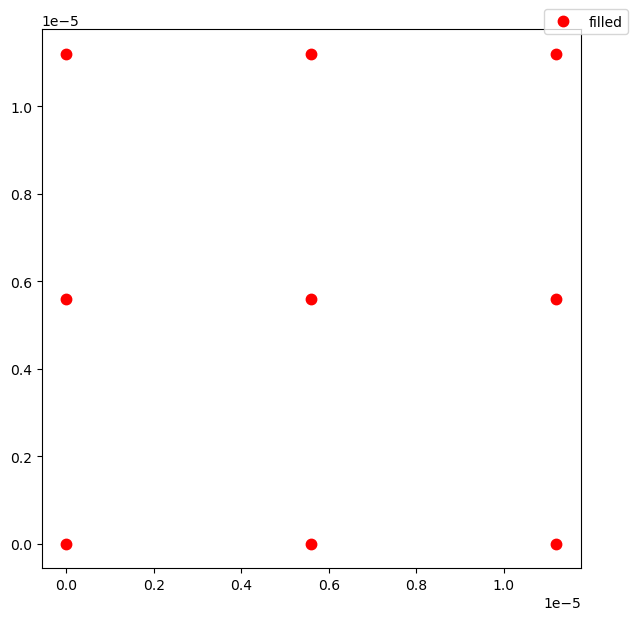

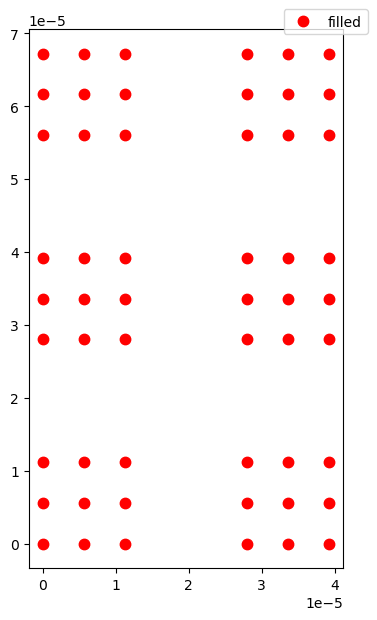

In [35]:
# [Optional] We visually inspect the register
from utils import show_register

show_register(register)
show_register(parallel_register)

## Creating the Checkerboard phase

We use the same values and timings for the Amplitude, Phase, and Detuning from the [Ordered phases in Rydberg Systems](./02_Ordered_phases_in_Rydberg_systems.ipynb) example 

In [9]:
from ahs_utils import get_drive

time_points = [0, 2.5e-7, 2.75e-6, 3e-6] # s

amplitude_min = 0
amplitude_max = 1.5708e7  # rad / s

detuning_min = -5.49778714e7  # rad / s
detuning_max = 5.49778714e7   # rad / s

amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]

drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

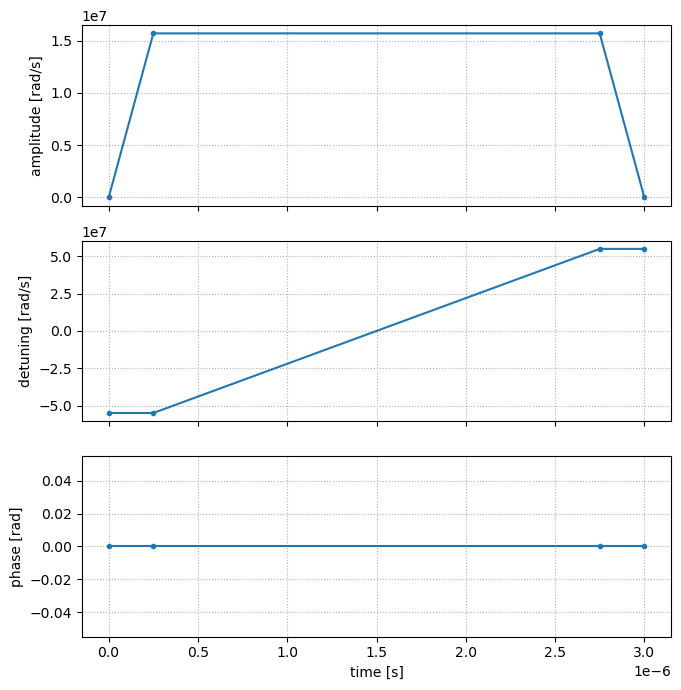

In [10]:
from ahs_utils import show_global_drive

# [Optional] We visually inspect the waveforms

show_global_drive(drive);

We now construct the AHS program to be run. Note that we create two programs and execute them to allow us to compare the accuracy of our results, with `parallel_ahs_program` being run on Aquila and `ahs_program` just being simulated with the local simulator. 

In [11]:
parallel_ahs_program = AnalogHamiltonianSimulation(
    register=parallel_register, 
    hamiltonian=drive
)

ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)

ahs_program = ahs_program.discretize(qpu)
parallel_ahs_program = parallel_ahs_program.discretize(qpu)

NameError: name 'parallel_register' is not defined

In [40]:
shots = 100

from braket.devices import LocalSimulator
sim = LocalSimulator("braket_ahs")


qpu_result = qpu.run(parallel_ahs_program, shots=shots).result()
sim_result = sim.run(ahs_program, shots=len(batch_mapping)*shots).result()

After running the separate programs, we can analyze the results.

We average the data across all the batches that ran in parallel across multiple shots, represented visually as a single batch versus the simulator result which just ran a single batch.

In [48]:
# collecting QPU Data

all_sequences = []
for measurement in qpu_result.measurements:
    # iterate over key and values
    for (ix,iy),inds in batch_mapping.items():
        batch_sequence = list(measurement.post_sequence[inds])
        all_sequences.append(batch_sequence)

all_rydberg = 1 - np.array(all_sequences)
qpu_density = all_rydberg.mean(axis=0)


KeyboardInterrupt: 

In [ ]:
# plot density of all batches that ran in parallel with geometry and averaged values of single batch
plot_avg_density_2D(qpu_density, parallel_register, batch_mapping=batch_mapping);

In [47]:
from utils import get_avg_density
sim_density = get_avg_density(sim_result)

# plot density of simulator result
plot_avg_density_2D(sim_density, register);

As we can see from the results, the simulated single batch result and the results from the batches running in parallel line up with what we expect for the $Z_{2}$ phase.